## AlphaZero Implementation
One step demonstration

#### Import common library

In [1]:
import torch
import time
import shlex
import hashlib
from collections import defaultdict
import numpy as np
import dill

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Import MCTS library

In [3]:
from MCTS.utils import *
from MCTS.Agent import *
from MCTS.MCTS import *

# note: The MCTS library was designed for 'vanilla' MCTS and not specially 
# for Zero's implemetation. We shall modify the library as we go by.

#### Import game rules

In [4]:
import rules.Othello as Othello
# shorthands
OthelloGame   = Othello.OthelloGame   
OthelloHelper = Othello.OthelloHelper

#### Define hyperparameters

In [5]:
# MCTS search related
c = 1.2
allowed_time = 5

# Game specific
state_memory_n = 1
board_size = [8, 8]

#### Import and implement data structure for the game

In [6]:
class OthelloDataNode(ZeroDataNode):
    def __init__(self, name, Game=OthelloGame, player=1):
        super().__init__(Game=Game, name=name, player=player)
    # end def
# end class

#### Import a pre-trained model (on human expert dataset)

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # define functionals
        self.fc1     = torch.nn.Linear(64, 100)
        self.norm1   = torch.nn.BatchNorm1d(100)
        self.relu1   = torch.nn.ReLU()
        self.fc2     = torch.nn.Linear(100, 62)
        self.softmax = torch.nn.Softmax()
        self.sigmoid = torch.nn.Sigmoid()
    # end def
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out_p, out_v = torch.split(out, (61, 1), 1)
        out_p = self.softmax(out_p)
        out_v = self.sigmoid(out_v)
        out = torch.cat((out_p, out_v), 1)
        return out
    # end def
# end class

model_file = 'expert_prediction/data/models/oth_exp_pred-iter03500.dill'
with open(model_file, 'rb') as fin:
    net = dill.load(fin)
# end with

# copy to cpu and makes to evaluation mode
net = net.cpu().eval()

#### wrap the neuralnet in a predictor

In [8]:
def parse_move_probs(move_probs):
    '''parse neuralnet output to dict of vector'''
    label2move = {0: [0, 0], 1: [0, 1], 2: [0, 2], 3: [0, 3], 4: [0, 4], 5: [0, 5], 6: [0, 6], 
                  7: [0, 7], 8: [1, 0], 9: [1, 1], 10: [1, 2], 11: [1, 3], 12: [1, 4], 13: [1, 5], 
                  14: [1, 6], 15: [1, 7], 16: [2, 0], 17: [2, 1], 18: [2, 2], 19: [2, 3], 20: [2, 4], 
                  21: [2, 5], 22: [2, 6], 23: [2, 7], 24: [3, 0], 25: [3, 1], 26: [3, 2], 27: [3, 5], 
                  28: [3, 6], 29: [3, 7], 30: [4, 0], 31: [4, 1], 32: [4, 2], 33: [4, 5], 34: [4, 6], 
                  35: [4, 7], 36: [5, 0], 37: [5, 1], 38: [5, 2], 39: [5, 3], 40: [5, 4], 41: [5, 5], 
                  42: [5, 6], 43: [5, 7], 44: [6, 0], 45: [6, 1], 46: [6, 2], 47: [6, 3], 48: [6, 4], 
                  49: [6, 5], 50: [6, 6], 51: [6, 7], 52: [7, 0], 53: [7, 1], 54: [7, 2], 55: [7, 3], 
                  56: [7, 4], 57: [7, 5], 58: [7, 6], 59: [7, 7], 60: 'PASS'}
    move2label = {tuple(q): p for p, q in label2move.items()}

    z = copy.deepcopy(move_probs)
    z = {tuple(label2move[i]): z[i] for i in range(len(z))}
    z['PASS'] = z.pop(tuple('PASS'))
    return z
# end def

def nnet_pred(state_in):
    # TODO: currently only for black
    state_in = state_in[-1] # Othello uses only last step
    data_in = state_in.data.flatten()
    
    # call the net for prediction
    net_outputs = net(torch.from_numpy(np.array([data_in])).float())[0].detach().numpy()
    # split into move prob and winner pred
    P, v = net_outputs[:-1], net_outputs[-1] #np.split(net_outputs, [len(net_outputs)-1, ])    
    P = parse_move_probs(P)
    return P, v
# end def

In [9]:
'''
_mid = [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, -1, 1, -1, 1, 
        -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 
        -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 
        1, 1, -1, -1, -1, -1, -1, 0, 1, 1, -1, -1, 
        -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0]
print(nnet_pred(_mid))
''';

#### Define exit conditions

In [10]:
def exit_cond(time0, time_thr):
    # time based
    if time.time() - time0 > time_thr:
        return True
    # end if
    
    # winning prob based
    # TODO
# end def

#### Main logic

In [11]:
def start_mcts(node, allowed_time):
    assert node.parent is None
    winner_value_dict = {1: 1, -1: 0, 0: 0.5}

    _iter = 0
    time0 = time.time()
    while True:
        _iter += 1
        if _iter % 100 == 0:
            print('iteration: %d' % (_iter,))
        # end if
        
        # check exit condition
        if exit_cond(time0, allowed_time):
            print('iteration: %d' % (_iter,))
            break
        # end if

        # dynamically expand the tree - search for first un-expanded node
        det_end_game = False
        while True:
            # if end game, break loop and proceed to backprop
            _winner = OthelloGame.get_winner(node.state)
            if _winner is not None:
                det_end_game = True
                break
            # end if
            
            # exit loop if found the unexpanded node
            if node.expanded() is False:
                break
            else:
                # choose node
                # 1. compute Q value for every node
                N = sum(node.N.values())
                actions = list(node.Q.keys())
                U = {key: None for key in actions}
                V = []
                for a in actions:
                    U[a] = c*np.sqrt(N) / (1+node.N[a]) * node.P[a]
                    V.append(node.Q[a] + U[a])
                # end for

                # 2. choose action that maximizes V
                idx = np.argmax(V)
                action = actions[idx]
                node = node.child_dict[action]
            # end if
        # end while

        # if end_game, simply evaluate
        if det_end_game is True:
            v = winner_value_dict[_winner]
            node.backprob(v)
            continue
        # end if

        # if not, expand and evaluate
        # - list all possible moves
        child_nodes = node.grow_branches() 
        # append legal child nodes
        node.append_children(child_nodes)

        # - neuralnet evaluation here
        P, v = nnet_pred(node.state)

        # back-propagation
        node.assign_probs(P)
        node.backprob(v)

        # go back to root
        node = node.root
    # end while
    
    return node
# end def

#### Initialize the board

In [12]:
new_board = OthelloHelper.new_board()

In [13]:
init_state = [stateType(data=new_board, player=1) for _ in range(state_memory_n)]

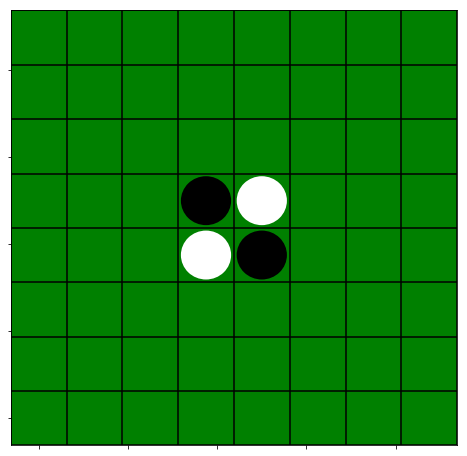

In [14]:
# show the board (optional)
OthelloHelper.print_board(init_state[0])

#### Initialize a node

In [15]:
node = OthelloDataNode("root")
node.state = init_state

In [16]:
# sample the node
sampled_node = start_mcts(node, allowed_time=allowed_time)

/home/kuanpern/AlphaZeroOthello/dev/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


iteration: 100
iteration: 200
iteration: 300
iteration: 400
iteration: 500
iteration: 600
iteration: 700
iteration: 800
iteration: 900
iteration: 935


In [24]:
tree_txt = sampled_node.print_tree()
print('\n'.join(tree_txt.splitlines()[:20]))

/
 -(2, 3): 0.56
 -(5, 4): 0.55
  -(3, 5): 0.53
   -(2, 2): 0.53
    -(3, 2): 0.50
     -(2, 1): 0.48
     -(2, 3): 0.50
      -(1, 2): 0.55
      -(5, 2): 0.50
       -(2, 1): 0.45
       -(4, 5): 0.50
        -(1, 2): 0.51
         -(0, 1): 0.49
        -(1, 4): 0.52
         -(1, 2): 0.51
          -(0, 2): 0.52
           -(0, 1): 0.46
        -(2, 5): 0.47
         -(1, 5): 0.45


mean: 0.5550589496248661
stdev: 0.05752227545384137


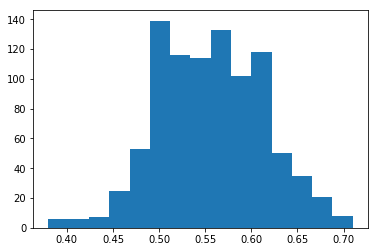

In [18]:
ps = [float(line.split()[-1]) for line in tree_txt.splitlines()[1:]]
plt.hist(ps, 15);
print('mean:', np.mean(ps))
print('stdev:', np.std(ps))

In [19]:
# first mover advantages of 5% ?

#### Choose a node using the tree search result

In [20]:
def choose_most_visited_child_node(node):
    chosen  = None
    max_val = None
    for key, val in node.N.items():
        if chosen is None:
            chosen = key
        # end if
        if max_val is None:
            max_val = val
        # end if
        
        if val > max_val:
            max_val = val
            chosen = key
        # end of
    # end for
    return node.child_dict[key]
# end def


In [21]:
chosen_node = choose_most_visited_child_node(sampled_node)

#### Print the selected action

In [22]:
print(chosen_node.action)

(5, 4)
